<h1 style="font-family:verdana;"> <center>💻🧠DL for Medical Imaging in Lung Cancer💻🧠</center> </h1>
<p><center style="color:#159364; font-family:cursive; font-size:20px;">Joash Voon </center></p>

# ❓**PROBLEM DEFINITION**
<div style="background-color:#f2f2f2; padding: 20px;">
  <p style="font-size:20px; font-family:verdana; line-height: 1.7em">
Lung cancer remains a significant global health challenge, with its early detection and type classification being crucial for effective treatment. One detection method involves analyzing CT scan images. These images can then be interpreted by doctors to determine the presence and type of lung cancer. However, this method has limitations; human interpretation may miss subtle patterns indicative of early-stage lung cancer. In contrast, deep learning models offer a promising avenue on this matter. They excel in recognizing intricate patterns, identifying subtle abnormalities not easily observable through other methods. Another advantage is they automatically learn relevant features from data, eliminating the need for manual feature engineeing, which is particulary usefull in medical imaging where definining explicit features can be complex.
      <p style="font-size:20px; font-family:verdana; line-height: 1.7em">
      In this study, we use a dataset containing CT scan images of lungs categorized as normal, squamous cell carcinoma, adenocarcinoma and large cell carcinoma. Our objective is to train three different models (VGG16, Inceptionv3 and EfficientNetB0), compare their accuracy and make predictions with the one with hightest accuracy.

# 🏗️**LIBRARY IMPORT**
<div style="background-color:#f2f2f2; padding: 20px;">
  <p style="font-size:20px; font-family:verdana; line-height: 1.7em">
Import necessary libraries for the script. The first libraries are used to interact with the operative system, numerical operations and data visualization.
      <p style="font-size:20px; font-family:verdana; line-height: 1.7em">
The following ones are specific to machine learning and neural network. TensorFlow is a machine learning framework used to build and deploy machine learning models. Keras is a high-level neural networks API that runs on top of TensorFlow and its used to build, train and deploy neural networks. Keras functionality with TensorFlow is integrated thanks to the "tensorflow.keras" library. 
      <p style="font-size:20px; font-family:verdana; line-height: 1.7em">
In this code, the Keras library modules are imported to serve as tools for specific tasks, such as defining distinct layer types, constructing models, preprocessing image data, implementing callbacks, leveraging pre-trained models for transfer learning, and loading pre-trained models for reuse.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout
from tensorflow.keras import Model 
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3


import warnings
warnings.filterwarnings("ignore")

# 🔍**DATA EXPLORATION AND VISUALIZATION**

In [2]:
# File Directory for both the train and test
train_path = "Data/train"
val_path = "Data/valid"
test_path = "Data/test"

In [3]:
# Define function to count number of images per class using a dictionary
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # count files in the folder
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;

# Get the number of images per class in each set (train, validation and test)
train_set = GetDatasetSize(train_path)
val_set = GetDatasetSize(val_path)
test_set = GetDatasetSize(test_path)
print(train_set,"\n\n",val_set,"\n\n",test_set)

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 195, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 115, 'normal': 148, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 155} 

 {'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 23, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 21, 'normal': 13, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 15} 

 {'adenocarcinoma': 120, 'large.cell.carcinoma': 51, 'normal': 54, 'squamous.cell.carcinoma': 90}


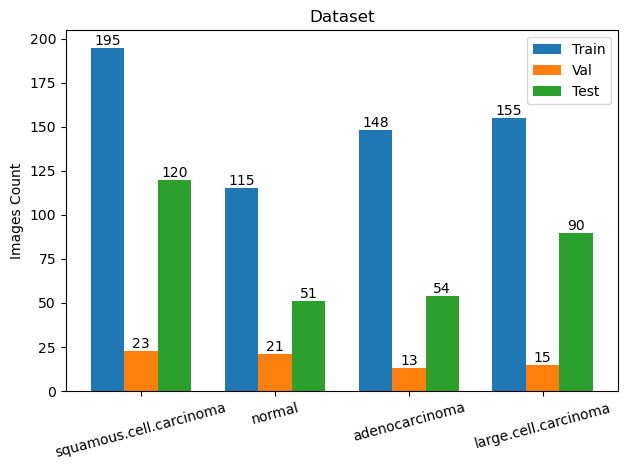

In [4]:
# Labels for each classs
labels = ['squamous.cell.carcinoma', 'normal', 'adenocarcinoma', 'large.cell.carcinoma']

# Create lists from previous dictionaries storing the count of images per category
train_list = list(train_set.values())
val_list = list(val_set.values())
test_list = list(test_set.values())

# Labels location and bars widht 
x = np.arange(len(labels))  
width = 0.25  

# Create plot and 3 sets of bars (train, val, test)
fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_list, width, label='Train')
rects2 = ax.bar(x, val_list, width, label='Val')
rects3 = ax.bar(x + width, test_list, width, label='Test')

# Add labels, title, legend, count values...
ax.set_ylabel('Images Count')
ax.set_title('Dataset')
ax.set_xticks(x, labels)
plt.xticks(rotation=15)
ax.legend()
ax.bar_label(rects1)
ax.bar_label(rects2)
ax.bar_label(rects3)

# Optimized layout and displaying plot
fig.tight_layout()
plt.show()

# ⚙️**DATA PREPROCESSING**
<div style="background-color:#f2f2f2; padding: 20px;">
  <p style="font-size:20px; font-family:verdana; line-height: 1.7em">
Data augmentation is performed to artificially increase the diversity of the training dataset by applying various transformations to the existing training samples. As a result, the model's generalization and robustness to different variations in the input data is improved.

In [5]:
# Image data generator with specified augmentation configurations (mostly geometric transformations)
train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  horizontal_flip = True,
                                  fill_mode = 'nearest',
                                  zoom_range=0.2,
                                  shear_range = 0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  rotation_range=0.4)

# Using data generator to create augmented data from image files in train_path directory
train_data = train_datagen.flow_from_directory(train_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')

# Dicctionary with class names to their respective indices in the generated data
train_data.class_indices

Found 613 images belonging to 4 classes.


{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [6]:
val_datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_data = val_datagen.flow_from_directory(val_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')
val_data.class_indices

Found 72 images belonging to 4 classes.


{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [7]:
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_data = test_datagen.flow_from_directory(test_path,
                                                   batch_size = 5,
                                                   target_size = (350,350),
                                                   class_mode = 'categorical')
test_data.class_indices

Found 315 images belonging to 4 classes.


{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

# 👀**SAMPLE VISUALIZATION**
<div style="background-color:#f2f2f2; padding: 20px;">
  <p style="font-size:20px; font-family:verdana; line-height: 1.7em">
Ensuring that data preprocessing has been correctly applied and checking whether the labels are correctly assigned.

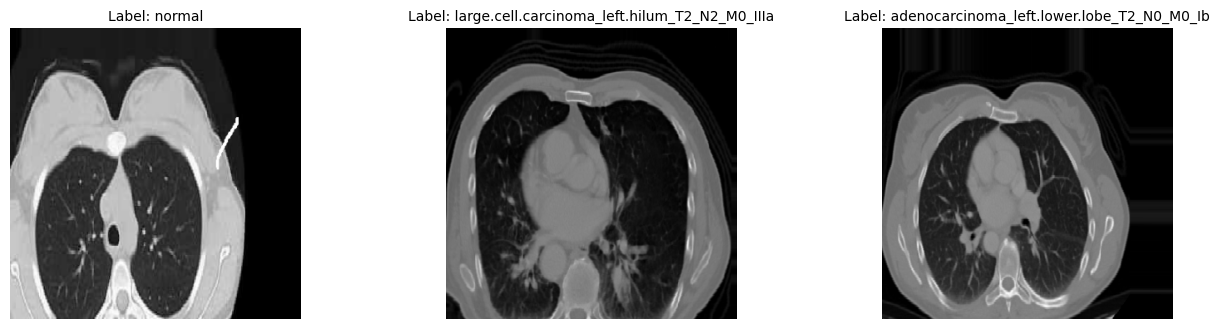

In [8]:

# Function to plot sample images with labels
def plot_sample_images(images, labels, class_indices):
    class_labels = list(class_indices.keys())
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))  
    fig.subplots_adjust(wspace=0.5)  # Adjust the width space between subplots

    for i in range(len(images)):
        axs[i].imshow(images[i])
        axs[i].set_title("Label: {}".format(class_labels[np.argmax(labels[i])]), fontsize=10)  # Adjust fontsize as needed
        axs[i].axis('off')

    plt.show()

# Sample and plotting of 3 images with their respective labels from train_data
sample_images, sample_labels = next(train_data)
plot_sample_images(sample_images[:3], sample_labels[:3], train_data.class_indices)

# **VGG 16**
<div style="background-color:#f2f2f2; padding: 20px;">
  <p style="font-size:20px; font-family:verdana; line-height: 1.7em">
VGG-16, short for Visual Geometry Group 16-layer, is a deep convolutional neural network architecture designed for image classification. It was introduced by the Visual Geometry Group at the University of Oxford in 2014. The VGG architecture gained popularity for its simplicity and effectiveness, and it served as a foundation for many subsequent deep learning models.

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">
However, it has a relatively large number of parameters, making it computationally expensive. More recent architectures, such as ResNet and EfficientNet, have since surpassed VGG in terms of performance and efficiency.
      
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">
Trained on the ImageNet dataset, this model exhibits an accuracy exceeding 80%. 
      
 <p style="font-size:20px">
    <strong>Batch size</strong>: 32<br>
    <strong>Epochs</strong>: 32<br>
    <strong>Input Shape</strong>: (350, 350, 3)<br>
    <strong>Output layer</strong>: 16
  </p>
</div>

In [9]:
base_model = VGG16(
    weights='imagenet',
    include_top=False, 
    input_shape=(350,350,3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


# 🚄Training the model

In [10]:
# We define the number of classes in the classification problem.
NUM_CLASSES = 4

# First, a sequential model is created, which will be used to build the VGG model.
vgg_model = Sequential()

# Se agrega una capa al modelo. base_model el modelo anteriormente preentrenado.
vgg_model.add(base_model)

# A flattening layer (Flatten) is added. This layer converts the output from the 
# previous layer (which is likely a three-dimensional tensor) into a one-dimensional vector.
vgg_model.add(layers.Flatten())

# A Dropout layer is added with a dropout rate of 25%. Dropout is used to prevent overfitting 
# by randomly disconnecting some neurons during training.
vgg_model.add(layers.Dropout(0.25))

# A dense layer is added with NUM_CLASSES neurons and a sigmoid activation function. 
# This layer produces the final output of the model.
vgg_model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

# The first layer of the model (base_model) is frozen, so the weights of this layer 
# will not be updated during training.
vgg_model.layers[0].trainable = False

# The model is compiled with the 'categorical_crossentropy' loss function,
#' adam' optimizer, and the accuracy metric. This prepares the model for training.
vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [12]:
mc = ModelCheckpoint(
    filepath="./ct_vgg_best_model.keras",
    monitor= 'val_accuracy', 
    verbose= 1,
    save_best_only= True, 
    mode = 'auto'
    );

call_back = [ mc];

In [13]:
# Fitting the Model
vgg = vgg_model.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 32, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back 
    )

Epoch 1/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.3922 - loss: 2.8881
Epoch 1: val_accuracy improved from -inf to 0.48571, saving model to ./ct_vgg_best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 48s 383ms/step - accuracy: 0.3929 - loss: 2.8825 - val_accuracy: 0.4857 - val_loss: 1.6764
Epoch 2/32
  1/122 ━━━━━━━━━━━━━━━━━━━━ 40s 336ms/step - accuracy: 0.4000 - loss: 1.9743
Epoch 2: val_accuracy did not improve from 0.48571
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.4000 - loss: 1.9743 - val_accuracy: 0.4857 - val_loss: 1.8234
Epoch 3/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.5735 - loss: 1.6279
Epoch 3: val_accuracy improved from 0.48571 to 0.55714, saving model to ./ct_vgg_best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 47s 385ms/step - accuracy: 0.5734 - loss: 1.6308 - val_accuracy: 0.5571 - val_loss: 4.3718
Epoch 4/32
  1/122 ━━━━━━━━━━━━━━━━━━━━ 41s 340ms/step - accuracy: 0.6000 - loss: 1.5318
Epoch 4: val_accuracy improved from 0.55714 

# ✔️Model Evaluation
<div style="background-color:#f2f2f2; padding: 20px;">
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The test dataset will be used to evaluate the performance of the model. The metrics that will be measured are: 
    
<h3>Accuracy(A):</h3> 
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">For the purpose of evaluating the performance of the current model and future models, the accuracy metric will be employed. Accuracy measures the proportion of instances correctly classified out of the total instances. It is a general measure of the model's effectiveness across all classes.</p>
    
  <h4>
  <center>
    <span style="font-size: 1.5em">
      $A = \frac{TP+TN}{TI}$
    </span>
  </center>
</h4>
    
<h3>Loss: </h3> 
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">Loss is a measure of how well the model is performing the task for which it was trained. It represents the discrepancy between the model's predictions and the actual labels. A low loss value indicates that the model is making predictions that fit well with the training data.</p>

In [57]:
# Loading the Best Fit Model 
model = load_model("./ct_vgg_best_model.keras")

# Checking the Accuracy of the Model 
accuracy_vgg = model.evaluate(test_data)[1]
print(f"The accuracy of the model is = {accuracy_vgg*100} %")
loss_vgg = model.evaluate(test_data)[0]
print(f"The loss of the model is = {loss_vgg} %")

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 338ms/step - accuracy: 0.6640 - loss: 1.9949
The accuracy of the model is = 66.34920835494995 %
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 343ms/step - accuracy: 0.6169 - loss: 2.4009
The loss of the model is = 2.0272998809814453 %


# **INCEPTIONV3**
<div style="background-color:#f2f2f2; padding: 20px;">
  <p style="font-size:20px; font-family:verdana; line-height: 1.7em">
InceptionV3 is a convolutional neural network (CNN) model developed by Google as part of the Inception family of architectures. It is designed for image recognition and classification tasks. The "V3" indicates that it's the third iteration of this architecture. It was designed to improve performance and efficiency compared to its predecessors.

      
  <p style="font-size:20px; font-family:verdana; line-height: 1.7em">
This model has been trained on the ImageNet dataset, showing greater than 78.1%  of accuracy. 
      
 <p style="font-size:20px">
    <strong>Batch size</strong>: 32<br>
    <strong>Epochs</strong>: 32<br>
    <strong>Input Shape</strong>: (350, 350, 3)<br>
    <strong>Output layer</strong>: 1024
  </p>
</div>

In [19]:
base_model = InceptionV3(input_shape = (350, 350, 3), 
                         include_top = False, 
                         weights = 'imagenet')

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


# 🚄Training the model

In [20]:
# The code then iterates through all layers in the base InceptionV3 model. 
# This means that during training, these layers will not be updated, preserving the pre-trained knowledge.
for layer in base_model.layers:
    layer.trainable = False

In [21]:
# First, we flatten the information coming out of InceptionV3 (making it simpler).
# We aded another layer for better understanding of the flattened information
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Finally, we add a layer with 4 'neurons' that will help us classify things into different categories.
x = layers.Dense(4, activation='sigmoid')(x)

# We put together the original InceptionV3 and our new custom parts 
model_incep = tf.keras.models.Model(base_model.input, x)

# Compile up the rules and tools for training your neural network. 
# The optimizer determines how the model should update its internal parameters, the loss function quantifies how well the model is doing, and the metrics provide additional measures to track the model's performance.
model_incep.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), 
                    loss = 'categorical_crossentropy', 
                    metrics = ['accuracy'])

In [23]:
# Adding Model check point Callback

mc = ModelCheckpoint(
    filepath="./ct_incep_best_model.keras",
    monitor= 'val_accuracy', 
    verbose= 1,
    save_best_only= True, 
    mode = 'auto'
    );

call_back = [mc];

In [24]:
# Fitting the Model
incep = model_incep.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 32, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back 
    )

Epoch 1/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.3887 - loss: 12.4205
Epoch 1: val_accuracy improved from -inf to 0.44286, saving model to ./ct_incep_best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 80s 618ms/step - accuracy: 0.3892 - loss: 12.3770 - val_accuracy: 0.4429 - val_loss: 2.9213
Epoch 2/32
  1/122 ━━━━━━━━━━━━━━━━━━━━ 1:08 565ms/step - accuracy: 0.4000 - loss: 3.5887
Epoch 2: val_accuracy did not improve from 0.44286
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4000 - loss: 3.5887 - val_accuracy: 0.4143 - val_loss: 2.6911
Epoch 3/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.5688 - loss: 2.5317
Epoch 3: val_accuracy did not improve from 0.44286
122/122 ━━━━━━━━━━━━━━━━━━━━ 71s 582ms/step - accuracy: 0.5686 - loss: 2.5310 - val_accuracy: 0.3714 - val_loss: 2.4184
Epoch 4/32
  1/122 ━━━━━━━━━━━━━━━━━━━━ 1:08 569ms/step - accuracy: 0.4000 - loss: 3.4925
Epoch 4: val_accuracy improved from 0.44286 to 0.55714, saving model to ./ct_incep_be

# ✔️Model Evaluation

In [52]:
# Loading the Best Fit Model 
model = load_model("./ct_incep_best_model.keras")

# Checking the Accuracy of the Model 
accuracy_incep = model.evaluate(test_data)[1]
print(f"The accuracy of the model is = {accuracy_incep*100} %")
loss_incep = model.evaluate(test_data)[0]
print(f"The loss the model is = {loss_incep}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.7289 - loss: 0.7665
The accuracy of the model is = 74.92063641548157 %
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.7495 - loss: 0.6926
The loss the model is = 0.7145981788635254%


# **EfficientNetB0**

<div style="background-color:#f2f2f2; padding: 20px;">
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">EfficientNetB0 is a convolutional neural network (CNN) architecture that belongs to the EfficientNet family. Developed by Mingxing Tan and Quoc V. Le, EfficientNetB0 is specifically designed for image recognition and classification tasks. The "B0" signifies that it serves as the baseline or base model within the EfficientNet series.

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">It has been also trained on the ImageNet dataset, showing great accuracy for classification tasks.

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">
However, in comparison with the other models, EfficientNetB0 emphasizes a more balanced approach to model scaling, considering depth, width, and resolution simultaneously. It aims to achieve high performance with fewer parameters and computational resources. It is more efficient in terms of model size and computational cost.

 <div>
    <p style="font-size:20px">
    <strong>Batch size</strong>: 32<br>
    <strong>Epochs</strong>: 32<br>
    <strong>Input Shape</strong>: (350, 350, 3)<br>
    <strong>Output layer</strong>: 4
  </p>
</div>

In [28]:
base_model = EfficientNetB0(input_shape = (350, 350, 3), 
                         include_top = False, 
                         weights = 'imagenet')

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [33]:
mc = ModelCheckpoint(
    filepath="./ct_effnet_best_model.keras",
    monitor= 'val_accuracy', 
    verbose= 1,
    save_best_only= True, 
    mode = 'auto'
    );

call_back = [ mc];

tensorboard = TensorBoard(log_dir = 'logs')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

#We also add a earlystop for prevent the computer from wasting time if it's not making progress.


early_stopping = EarlyStopping(monitor='val_acc', patience=3, restore_best_weights=True, mode = 'max')

# 🚄Training the model

In [34]:
#Customize our base model
EffNetmodel = base_model.output
EffNetmodel = tf.keras.layers.GlobalAveragePooling2D()(EffNetmodel)
# to provide overfitting problem
EffNetmodel = tf.keras.layers.Dropout(rate=0.5)(EffNetmodel)

#Finally, we add a layer with 4 'neurons' that will help us classify things into different categories.
EffNetmodel = tf.keras.layers.Dense(4,activation='softmax')(EffNetmodel)

In [35]:
#We put together the original EfficientNetB0 and our new custom parts 
EffNetmodel = tf.keras.models.Model(inputs=base_model.input, outputs = EffNetmodel)

#Compile up the rules and tools for training your neural network. 
#The optimizer determines how the model should update its internal parameters, the loss function quantifies how well the model is doing, and the metrics provide additional measures to track the model's performance.
EffNetmodel.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [36]:
%time
EffNetB0 = EffNetmodel.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 32, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = [tensorboard, mc, reduce_lr, early_stopping]
    )

CPU times: total: 0 ns
Wall time: 0 ns
Epoch 1/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.4877 - loss: 1.1122
Epoch 1: val_accuracy improved from -inf to 0.18571, saving model to ./ct_effnet_best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 86s 491ms/step - accuracy: 0.4882 - loss: 1.1118 - val_accuracy: 0.1857 - val_loss: 1.6102 - learning_rate: 0.0010
Epoch 2/32
  1/122 ━━━━━━━━━━━━━━━━━━━━ 55s 455ms/step - accuracy: 0.8000 - loss: 0.6953
Epoch 2: val_accuracy did not improve from 0.18571
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8000 - loss: 0.6953 - val_accuracy: 0.1714 - val_loss: 1.6081 - learning_rate: 0.0010
Epoch 3/32
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.5981 - loss: 0.9540
Epoch 3: val_accuracy improved from 0.18571 to 0.31429, saving model to ./ct_effnet_best_model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 57s 465ms/step - accuracy: 0.5983 - loss: 0.9536 - val_accuracy: 0.3143 - val_loss: 1.5761 - learning_rate: 0.0010
Epoch 4/32
  1/1

# ✔️Model Evaluation

In [53]:
# Loading the Best Fit Model 
model_eff = load_model("./ct_effnet_best_model.keras")

# Checking the Accuracy of the Model 
accuracy_effnet = model_eff.evaluate(test_data)[1]
loss_effnet = model_eff.evaluate(test_data)[0]
print(f"The accuracy of the model is = {accuracy_effnet*100} %")
print(f"The loss of the model is = {loss_effnet} %")

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.8724 - loss: 0.3556
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.8827 - loss: 0.3169
The accuracy of the model is = 85.39682626724243 %
The loss of the model is = 0.3762017786502838 %


# **Model Comparison**
<div style="background-color:#f2f2f2; padding: 20px;">
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">
The accurate and timely identification of lung cancer from medical images is crucial for early diagnosis and effective treatment. To ensure the optimal performance of deep learning models, it is essential to conduct systematic comparisons. 

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">Basics for comparing these models include evaluating their accuracy and loss values for training and validation. However, other metrics such as precision, recall or F1-score should be considered.

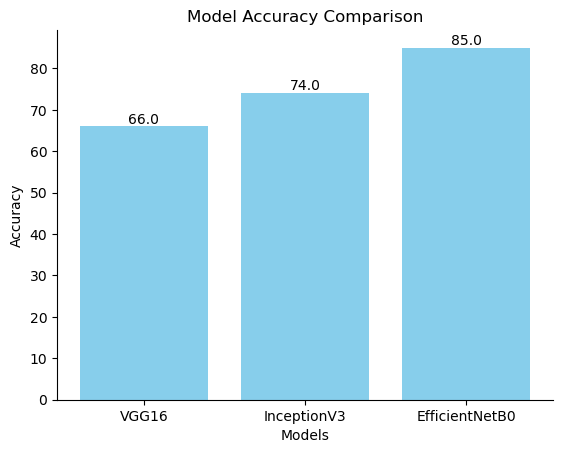

In [54]:
algos = ['VGG16', 'InceptionV3', 'EfficientNetB0']
accuracy1 = [accuracy_vgg, accuracy_incep, accuracy_effnet]
accuracy = np.floor([i * 100 for i in accuracy1])


fig, ax = plt.subplots()
bars = ax.bar(algos, accuracy, color='skyblue')

# Add data values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


plt.show()

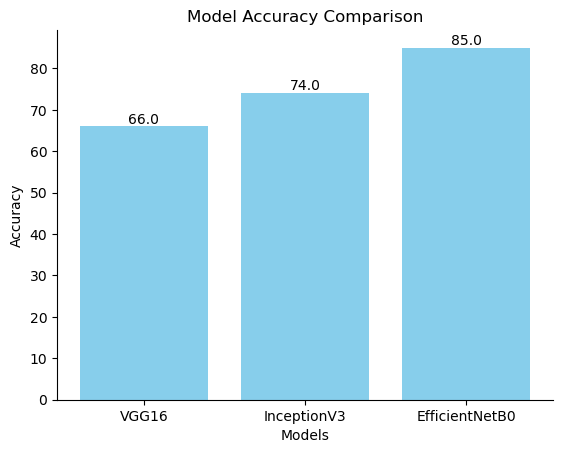

In [55]:
algos = ['VGG16', 'InceptionV3', 'EfficientNetB0']
accuracy = [accuracy_vgg, accuracy_incep, accuracy_effnet]
accuracy = np.floor([i * 100 for i in accuracy])


fig, ax = plt.subplots()
bars = ax.bar(algos, accuracy, color='skyblue')

# Add data values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


plt.show()


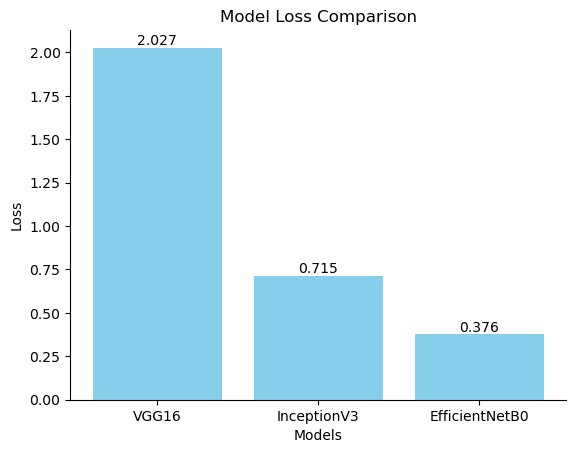

In [56]:

algos = ['VGG16', 'InceptionV3', 'EfficientNetB0']
loss = [loss_vgg, loss_incep, loss_effnet]

fig, ax = plt.subplots()
bars = ax.bar(algos, loss, color='skyblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

plt.xlabel('Models')
plt.ylabel('Loss')
plt.title('Model Loss Comparison')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


plt.show()

# Deployment Model


<div style="background-color:#f2f2f2; padding: 20px;">
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">A well-performing model strikes a balance between high accuracy and low loss. It's beneficial to consider both metrics simultaneously, looking for a model that achieves good accuracy without sacrificing generalization (as reflected in the validation loss).

# 📉Visualizing  accuracy and loss curves


<div style="background-color:#f2f2f2; padding: 20px;">
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">Interpreting a graph of accuracy for training and validation provides valuable insights into the performance of a machine learning model during training.

<h3>Accuracy Curve:</h3> 
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">
Ideally, the training accuracy tends to increase as the model learns from the training data. This indicates that the model is effectively capturing patterns and features in the training set. Over time, the training accuracy may reach a plateau. The validation accuracy will follow the same trend, indicating that the model is generalizing well to unseen data, mirroring its performance on the training set.

<h3>Loss Curve:</h3> 
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">
The training loss should generally exhibit a decreasing trend, indicating that the model is learning and optimizing its parameters to minimize the difference between predicted and actual values on the training data. Some fluctuations are normal, especially in the early epochs. The validation loss cruve should follow the same trend.

'wget' is not recognized as an internal or external command,
operable program or batch file.


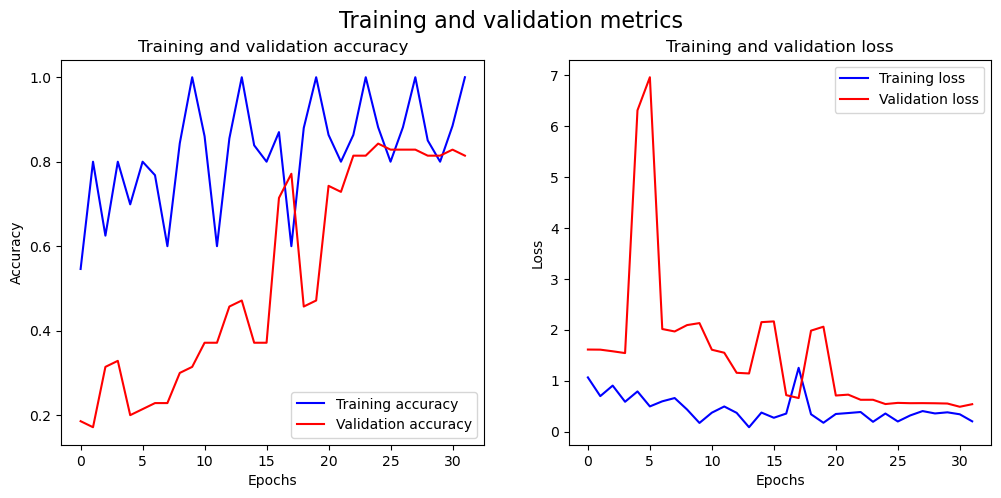

In [59]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

accuracy = EffNetB0.history['accuracy']
val_accuracy = EffNetB0.history['val_accuracy']

loss = EffNetB0.history['loss']
val_loss = EffNetB0.history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig.suptitle('Training and validation metrics', fontsize=16)
plt.show()

# 🔮Making predictions

In [60]:
def chestScanPrediction(path, _model, actual_label):
    classes_dir = ["Adenocarcinoma", "Large cell carcinoma", "Normal", "Squamous cell carcinoma"]
    num_images = len(paths)
    for i in range(num_images):
        # Loading Image
        img = image.load_img(paths[i], target_size=(350, 350))

        # Normalizing Image
        norm_img = image.img_to_array(img) / 255

        # Converting Image to Numpy Array
        input_arr_img = np.array([norm_img])

        # Getting Predictions
        pred = np.argmax(_model.predict(input_arr_img))

        # Printing Model Prediction
        print("Predicted Label:", classes_dir[pred])
        print("Actual Label:", classes_dir[actual_label[i]])
        
        # Displaying the image
        plt.imshow(img)
        plt.title("Actual Label: " + classes_dir[actual_label[i]] + "\nPredicted Label: " + classes_dir[pred])
        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Label: Large cell carcinoma
Actual Label: Large cell carcinoma


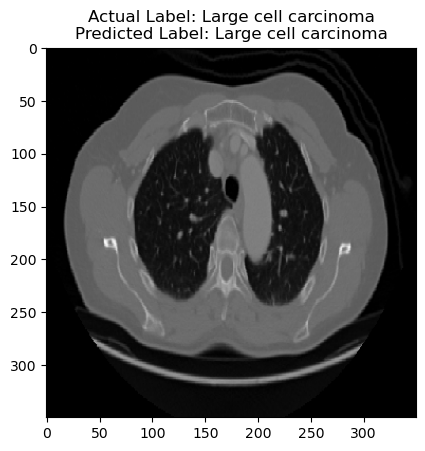

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted Label: Adenocarcinoma
Actual Label: Adenocarcinoma


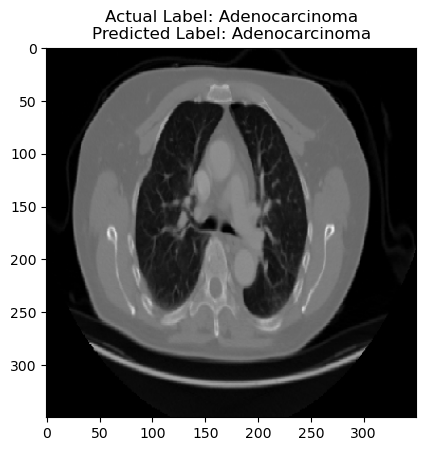

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Label: Normal
Actual Label: Normal


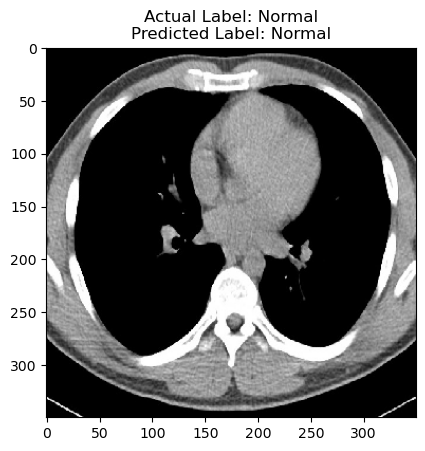

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Predicted Label: Squamous cell carcinoma
Actual Label: Squamous cell carcinoma


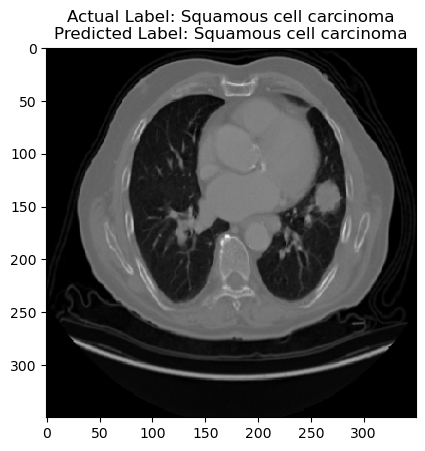

In [61]:
paths = [
    "Data/test/large.cell.carcinoma/000128.png",
    "Data/test/adenocarcinoma/000114.png",
    "Data/test/normal/21.png",
    "Data/test/squamous.cell.carcinoma/000119.png"
]

actual_labels = [1, 0, 2, 3]

chestScanPrediction(paths, EffNetmodel, actual_labels)